In [20]:
%pip install fastMONAI
from fastMONAI.vision_all import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
from google.colab import drive

drive.mount('/content/gdrive')

df = pd.read_csv('/content/gdrive/MyDrive/Datasets/datasetT1_100.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [22]:
df

,t1_path,subject_id,age_at_scan,age
0,/content/gdrive/MyDrive/Datasets/T1Restore100/sub-CC00051XX02_ses-7702_desc-restore_T1w.nii.gz,7702,40.00,40
1,/content/gdrive/MyDrive/Datasets/T1Restore100/sub-CC00052XX03_ses-8300_desc-restore_T1w.nii.gz,8300,38.71,38
2,/content/gdrive/MyDrive/Datasets/T1Restore100/sub-CC00053XX04_ses-8607_desc-restore_T1w.nii.gz,8607,40.43,40
3,/content/gdrive/MyDrive/Datasets/T1Restore100/sub-CC00054XX05_ses-8800_desc-restore_T1w.nii.gz,8800,42.14,42
4,/content/gdrive/MyDrive/Datasets/T1Restore100/sub-CC00055XX06_ses-9300_desc-restore_T1w.nii.gz,9300,40.43,40
...,...,...,...,...
95,/content/gdrive/MyDrive/Datasets/T1Restore100/sub-CC00165XX09_ses-54600_desc-restore_T1w.nii.gz,54600,41.14,41
96,/content/gdrive/MyDrive/Datasets/T1Restore100/sub-CC00168XX12_ses-55700_desc-restore_T1w.nii.gz,55700,43.86,43
97,/content/gdrive/MyDrive/Datasets/T1Restore100/sub-CC00171XX07_ses-56300_desc-restore_T1w.nii.gz,56300,40.43,40
98,/content/gdrive/MyDrive/Datasets/T1Restore100/sub-CC00172AN08_ses-56901_desc-restore_T1w.nii.gz,56901,37.86,37


In [23]:
df.age.min(), df.age.max(), df.age.mean()

(33, 44, 39.09)

In [24]:
import matplotlib.pyplot as plt

(array([ 0.,  0.,  0.,  0.,  2.,  2.,  5.,  4.,  9., 13., 13., 24., 19.,
         5.,  3.,  1.,  0.]),
 array([29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46.]),
 <BarContainer object of 17 artists>)

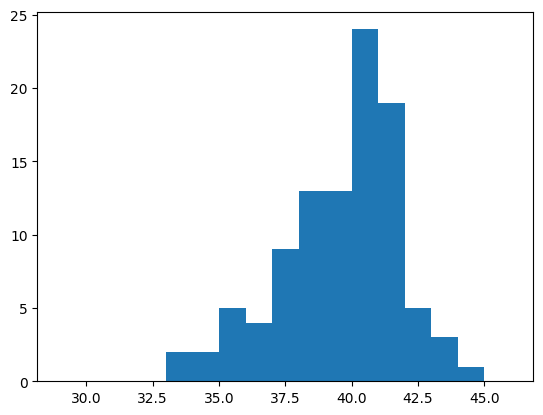

In [25]:
plt.hist(df['age'], bins = 17, range = [29,46])

In [26]:
med_dataset = MedDataset(path= '/content/gdrive/MyDrive/Datasets/T1Restore100', max_workers=12)
data_info_df = med_dataset.summary()

In [27]:
data_info_df.head()

,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,example_path,total
0,217,290,290,0.5,0.5,0.5,RAS+,/content/gdrive/MyDrive/Datasets/T1Restore100/sub-CC00051XX02_ses-7702_desc-restore_T1w.nii.gz,100


In [28]:
resample, reorder = med_dataset.suggestion()
resample, reorder

([0.5, 0.5, 0.5], False)

In [29]:
img_size = med_dataset.get_largest_img_size(resample=resample)
img_size

[217.0, 290.0, 290.0]

In [30]:

bs=4
item_tfms = [ZNormalization(), PadOrCrop(img_size), RandomAffine(scales=0, degrees=5, isotropic=False)] 
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), RegressionBlock), 
                      splitter=RandomSplitter(seed=32),
                      get_x=ColReader('t1_path'),
                      get_y=ColReader('age'),
                      item_tfms=item_tfms,
                      reorder=reorder,
                      resample=resample) 

In [31]:
dls = dblock.dataloaders(df, bs=bs)

In [32]:
len(dls.train_ds.items), len(dls.valid_ds.items)

(80, 20)

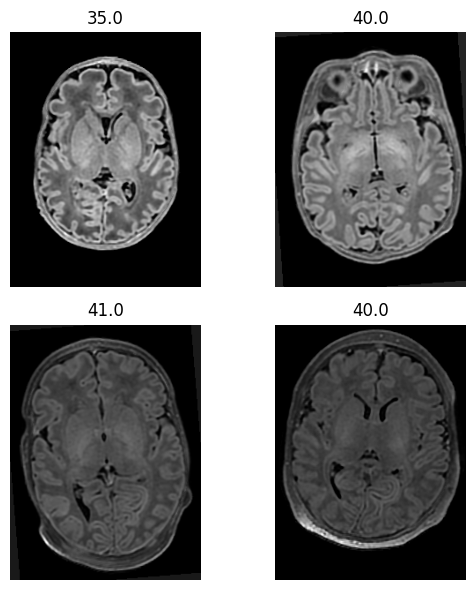

In [35]:
dls.show_batch(anatomical_plane=2)

In [36]:
from monai.networks.nets import Regressor

model = Regressor(in_shape=[1,217, 290, 290], out_shape=1, channels=(16, 32, 64, 128, 256),strides=(2, 2, 2, 2), kernel_size=3, num_res_units=2)

In [37]:
loss_func = L1LossFlat()
learn = Learner(dls, model, loss_func=loss_func, metrics=[mae])
learn.summary()

Regressor (Input shape: 4 x 1 x 217 x 290 x 290)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 16 x 109 x 145  
Conv3d                                    448        True      
InstanceNorm3d                            0          False     
PReLU                                     1          True      
Conv3d                                    6928       True      
InstanceNorm3d                            0          False     
PReLU                                     1          True      
Conv3d                                    448        True      
____________________________________________________________________________
                     4 x 32 x 55 x 73 x  
Conv3d                                    13856      True      
InstanceNorm3d                            0          False     
PReLU                                     1          True      
Conv3d                                    27680      True      
InstanceNorm3d        

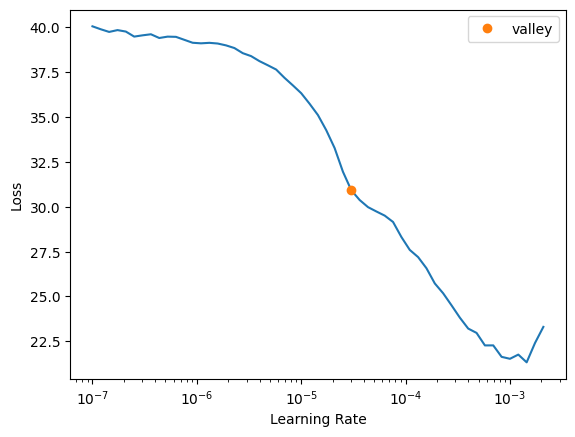

In [38]:
lr = learn.lr_find()

In [39]:
print(lr.valley)

3.0199516913853586e-05


In [40]:
learn.fit_one_cycle(4, lr.valley)

epoch,train_loss,valid_loss,mae,time
0,23.452038,5.574148,5.574148,24:28
1,11.876087,2.400054,2.400054,24:22
2,7.460090,2.148158,2.148158,24:21
3,5.258571,1.466296,1.466296,24:05


In [41]:
learn.save('model-brainage');
learn.load('model-brainage'); 


In [42]:
interp = Interpretation.from_learner(learn)

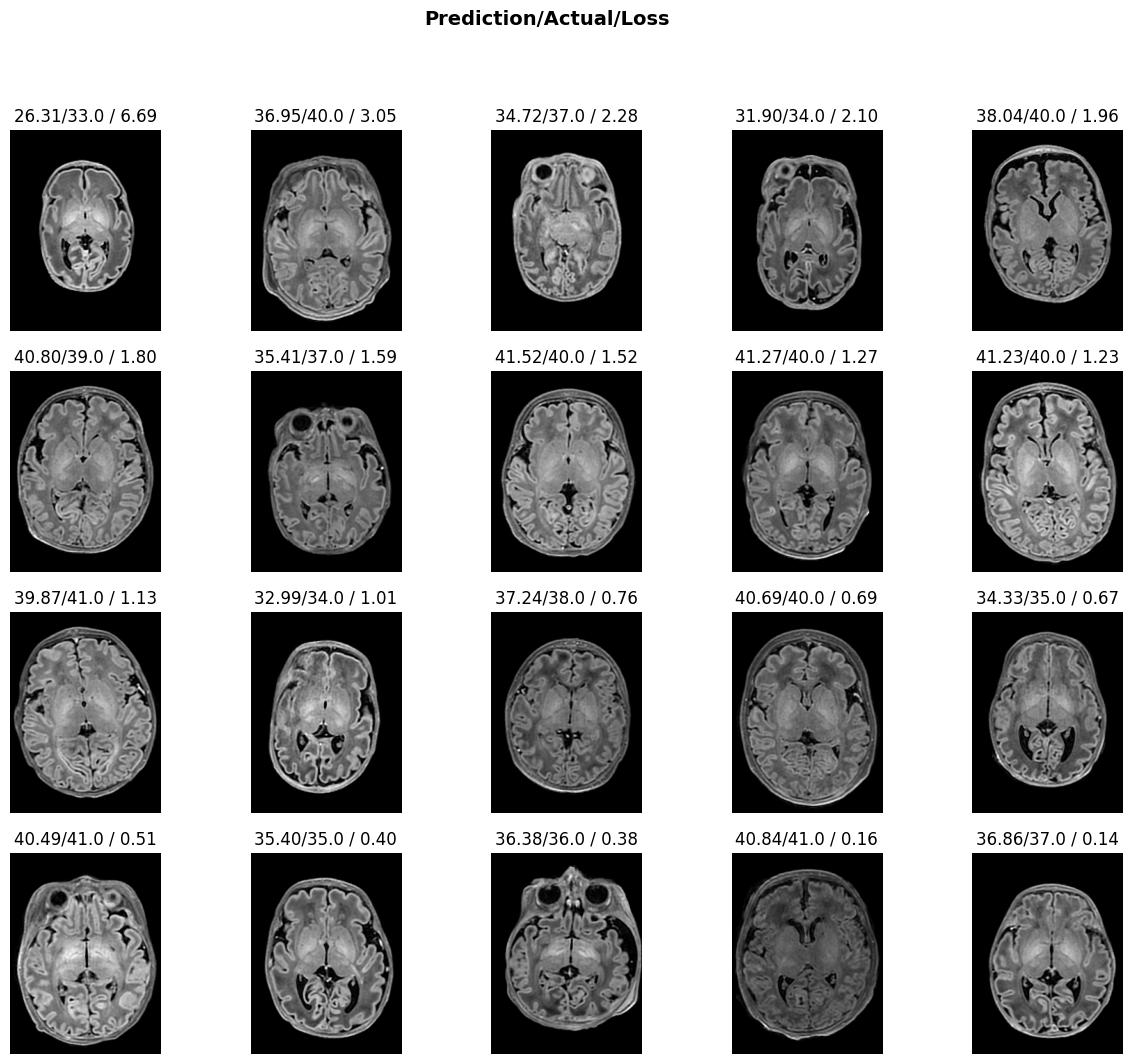

In [43]:
interp.plot_top_losses(k=20, anatomical_plane=2)